<h1 align="center"><strong>Social Graphs and Interactions: Assignment 2</strong></h1>
<p align="center">
<strong>Date:</strong> November 5th, 2024 <br>
<strong>Created by:</strong><br>
Johan Böcher Hanehøj (s194495) <br>
Melis Cemre Akyol (s232165) <br>
Md Jahidul Islam (s240010)
</p>

**NB:** The following assignment builds heavily upon the Country Music Network which was constructed during the exercises and for Assignment 1. The code for this network construction has only been altered slightly since the last submission - the code can be found in the Appendix under the name **A**. In this exercise we build upon the aforementioned graph by adding new node attributes such as the wikipedia content of each artist. The code for the continued work on the graph can be found in the appendix as **B**.

The data used for the construction as well as the saved graphs can be found in the root `data` folder on the following Github:
https://github.com/johan-bh/SocialGraphsAssignment2


# **Part 1: Genres and Communities and Plotting**

### **Genres and Modularity**

In our network of musical artists, each artist is associated with one or more genres based on the style of music they produce. Genres categorize artists into groups that share similar musical characteristics. This genre information provides a natural way to partition the network into communities.

**Modularity** is a measure used in network analysis to quantify the strength of division of a network into modules (or communities). It compares the density of edges inside communities to the density of edges between communities. A high modularity score indicates a strong community structure where there are many edges within communities and few edges between them.

By calculating the modularity of the network when partitioned by genres, we can assess how well the genres correspond to the actual structure of the network. Additionally, by detecting communities using algorithms like the Louvain method and comparing their modularity to that of the genre-based partitioning, we can understand whether the genres or the structurally detected communities better capture the underlying relationships in the network.

### **Loading the Network and Genre Data**

First, we need to load our undirected network of artists and their associated genres. 
Using the undirected version of the network results in a reduction of approximately 3k edges. 

Furthermore, because of the discreptancy of approximately 262 artists where the infoboxes were either iretrievable or simply did not exist we will end up with slightly fewer nodes corresponding to that discreptancy. 

From speaking to the TAs we have gathered that attempting to extract the missing infoboxes is out of scope. Thus, we will ensure that we only consider the nodes (artists) for which we have genre information:

In [ ]:
import networkx as nx
import json

# Load the existing Country Musician network
G = nx.read_graphml(r"data\new_country_musician_graph.graphml")
print(f"Initial number of odes & edges in the Country Music Network:")
print(f"- {G.number_of_nodes()} nodes")
print(f"- {G.number_of_edges()} edges")

# When we convert the graph to an undirected graph, we lose the information about the direction of the edges.
# Furthermore, we lose about 30% of the edges, since the graph is directed and we have both directions for each edge.
G = G.to_undirected()
print(f"\nNumber of nodes & edges after converting to undirected:")
print(f"- {G.number_of_nodes()} nodes")
print(f"- {G.number_of_edges()} edges")

# Load the genre information
with open(r'data\artists_genres_dictionary.json', 'r', encoding='utf-8') as f:
    artist_genres_data = json.load(f)

# Ensure artist names match between the graph and the genre dictionary
def normalize_name(name):
    return name.replace(' ', '_').lower()

artist_genres = {normalize_name(artist): genres for artist, genres in artist_genres_data.items()}

# Assign genres to nodes in the graph
for node in list(G.nodes()):
    node_name = normalize_name(node)
    if node_name in artist_genres and artist_genres[node_name]:
        G.nodes[node]['genre'] = artist_genres[node_name][0]  # Use the first genre
    else:
        # Remove nodes without genre information
        G.remove_node(node)

print(f"\nNumber of nodes after assigning genres and removing those without genres:")
print(f"- {G.number_of_nodes()} nodes")
print(f"- {G.number_of_edges()} edges")

Initial number of odes & edges in the Country Music Network:
- 2095 nodes
- 18217 edges

Number of nodes & edges after converting to undirected:
- 2095 nodes
- 15366 edges

Number of nodes after assigning genres and removing those without genres:
- 1833 nodes
- 14395 edges


### **Calculating Modularity Based on Genres**

Now, we'll calculate the modularity of the network when partitioned according to genres. Each genre represents a community, and we assign each node to the community corresponding to its primary genre.

#### **Modularity Explained**

Modularity $ M $ is defined as:

$$
M = \sum_{c=1}^{n_c} \left[ \frac{L_c}{L} - \left( \frac{k_c}{2L} \right)^2 \right]
$$

where:
- $ n_c $ is the number of communities (genres).
- $ L $ is the total number of edges in the network.
- $ L_c $ is the number of edges within community $ c $.
- $ k_c $ is the sum of the degrees of the nodes in community $ c $.

The modularity measures the difference between the actual density of edges within communities and the expected density if the edges were distributed randomly, preserving the same node degree distribution.
[Newman, M. E. J. *Network Science*, Chapter 9: Modularity](https://networksciencebook.com/chapter/9#modularity)

### **Computing the the community modularity**

As explain, we will have to partition the network into communities to compute the modularity. We continue with the undirected version of G where we have removed nodes without genre information.


In [54]:
# Prepare a mapping of artist to their first genre
artist_genres = {}
for artist, genres in artist_genres_data.items():
    if genres:
        artist_name = artist.replace(' ', '_')
        artist_genres[artist_name] = genres[0]

# Assign Communities Based on Genres
community_dict = {}
for node in G.nodes():
    if node in artist_genres:
        community_dict[node] = artist_genres[node]
    else:
        # Optionally remove nodes without genre information
        community_dict[node] = None
        print(f"Node {node} has no genre information")

# Sanity check. Remove nodes without genre information
nodes_to_remove = [node for node, genre in community_dict.items() if genre is None]
if nodes_to_remove:
    print(f"\nRemoving {len(nodes_to_remove)} nodes without genre information")
    G.remove_nodes_from(nodes_to_remove)

# Update the community dictionary
community_dict = {node: genre for node, genre in community_dict.items() if genre is not None}

In [ ]:
def calculate_modularity(G, community_map):
    # Total number of edges
    L = G.size(weight=None)
    
    # Get unique communities
    communities = set(community_map.values())
    
    modularity = 0.0
    for community in communities:
        # Nodes in this community
        nodes_in_community = [node for node, comm in community_map.items() if comm == community]
        
        # Calculate L_c: Number of edges within the community
        subgraph = G.subgraph(nodes_in_community)
        L_c = subgraph.size(weight=None)
        
        # Calculate k_c: Sum of degrees of nodes in the community
        k_c = sum(G.degree(node, weight=None) for node in nodes_in_community)
        
        # Increment modularity
        modularity += (L_c / L) - (k_c / (2 * L)) ** 2
    
    return modularity

# Load the community map
modularity_genre = calculate_modularity(G, community_dict)
print(f"\nModularity of the network (based on the first genre): {modularity_genre:.4f}")



Modularity of the network (based on the first genre): 0.0718


### **Detecting Communities Using the Louvain Algorithm**

Next, we'll detect communities using the Louvain algorithm, which optimizes modularity by iteratively grouping nodes into communities.

In [56]:
import community as community_louvain

partition_louvain = community_louvain.best_partition(G)

print(f"\nNumber of communities detected by the Louvain Algorithm: {len(set(partition_louvain.values()))}")

modularity_louvain = community_louvain.modularity(partition_louvain, G)
print(f"Modularity of Louvain partition: {modularity_louvain:.4f}")


Number of communities detected by the Louvain Algorithm: 15
Modularity of Louvain partition: 0.3763


### **Comparing Modularity Values**
Let's compare the modularity of the genre-based paritition to that of the Louvain partition.

In [57]:
print(f"Modularity of genre-based partition: {modularity_genre:.4f}")
print(f"Modularity of Louvain partition: {modularity_louvain:.4f}")

Modularity of genre-based partition: 0.0718
Modularity of Louvain partition: 0.3763


**Discussion:**

- The modularity of the genre-based partition is relatively low compared to the modularity obtained from the Louvain algorithm.
- This suggests that the genres, as assigned, do not perfectly capture the actual community structure of the network.
- The Louvain algorithm, by optimizing modularity, finds partitions that better reflect the dense connections within communities and sparser connections between them.

### **Creating the Confusion Matrix** $ \mathbf{D} $

We will create a confusion matrix $ D $ where:

- Rows represent the 7 most common genres.
- Columns represent the 7 largest communities detected by the Louvain algorithm.
- $ D(i, j) $ is the number of nodes that belong to genre $ i $ and community $ j $.

In [58]:
import numpy as np
import pandas as pd
from collections import Counter

# Normalize function to handle name matching
def normalize_name(name):
    return name.replace("_", " ")

# Apply normalization to artist_genres
normalized_artist_genres = {normalize_name(artist): genres for artist, genres in artist_genres_data.items()}

# Assign genres to each node in the graph
for node in G.nodes():
    normalized_node = normalize_name(node)
    if normalized_node in normalized_artist_genres:
        G.nodes[node]['genres'] = normalized_artist_genres[normalized_node]

# Identify the 7 most common genres and 7 largest communities
all_genres = [genre for genres in normalized_artist_genres.values() for genre in genres]
top_genres = [genre for genre, _ in Counter(all_genres).most_common(7)]

# Get the 7 largest communities
top_communities = [community_id for community_id, _ in Counter(partition_louvain.values()).most_common(7)]

# Initialize the confusion matrix
confusion_matrix = np.zeros((len(top_genres), len(top_communities)), dtype=int)

# Map genres and communities to indices for the confusion matrix
genre_to_index = {genre: i for i, genre in enumerate(top_genres)}
community_to_index = {community_id: i for i, community_id in enumerate(top_communities)}

# Populate the confusion matrix
for node in G.nodes():
    genres = G.nodes[node].get('genres', [])
    community = partition_louvain.get(node)

    # Consider only nodes that are part of top genres and top communities
    if community in top_communities:
        for genre in genres:
            if genre in top_genres:
                i = genre_to_index[genre]
                j = community_to_index[community]
                confusion_matrix[i, j] += 1

# Convert the confusion matrix to a DataFrame for easier interpretation
confusion_df = pd.DataFrame(confusion_matrix, index=top_genres, columns=[f"C{c+1}" for c in top_communities])

# Display with row and column highlights
def highlight_rows(s):
    # Example: highlight all rows in light blue
    return ['background-color: lightblue' for _ in s]

def highlight_max(s):
    # Highlight the maximum value in each row
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Apply the styling: light blue rows, yellow max values
display(confusion_df.style.apply(highlight_max, axis=1))

# Analyze the confusion matrix
for genre in top_genres:
    max_community = confusion_df.loc[genre].idxmax()
    print(f"Genre '{genre}' is most aligned with {max_community} based on node overlap.")


Genre 'country' is most aligned with C3 based on node overlap.
Genre 'folk' is most aligned with C4 based on node overlap.
Genre 'country rock' is most aligned with C3 based on node overlap.
Genre 'pop' is most aligned with C3 based on node overlap.
Genre 'americana' is most aligned with C4 based on node overlap.
Genre 'bluegrass' is most aligned with C2 based on node overlap.
Genre 'rock' is most aligned with C4 based on node overlap.


The confusion matrix reveals the distribution of country music performers across various genres and detected communities, highlighting that larger communities, such as C3 and C1, contain a diverse mix of genres, suggesting significant overlap and collaboration among artists. In contrast, smaller communities, like community C11, may represent niche genres, indicating potential areas for deeper exploration of genre evolution. These findings underscore the complexity of genre classification in contemporary music, where artists frequently navigate multiple genres.


<span style="color:red">**Discussion:**</span>
<span style="color:red">Comment further on what we see, the highlighted cells</span>
- The confusion matrix $ D $ shows how genres and communities overlap.
- High values in $ D(i, j) $ indicate that genre $ i $ and community $ j $ share many nodes.
- By analyzing $ D $, we can see whether certain genres are well-captured by specific communities or if the community structure cuts across genres.

## **Plotting the Communities**

Finally, we'll visualize the network, coloring the nodes based on their community assignments from the Louvain algorithm.

In [59]:
# Before plotting the network we will remove any isolated nodes as well as self-loops

# Remove self-loops
print(f"Removing {len(list(nx.selfloop_edges(G)))} self-loops")
G.remove_edges_from(nx.selfloop_edges(G))

# Remove isolated nodes
isolated_nodes = list(nx.isolates(G))
print(f"Removing {len(isolated_nodes)} isolated nodes")
G.remove_nodes_from(isolated_nodes)

Removing 3 self-loops
Removing 3 isolated nodes


100%|██████████| 2000/2000 [01:47<00:00, 18.56it/s]


BarnesHut Approximation  took  15.80  seconds
Repulsion forces  took  88.78  seconds
Gravitational forces  took  0.35  seconds
Attraction forces  took  0.44  seconds
AdjustSpeedAndApplyForces step  took  1.19  seconds


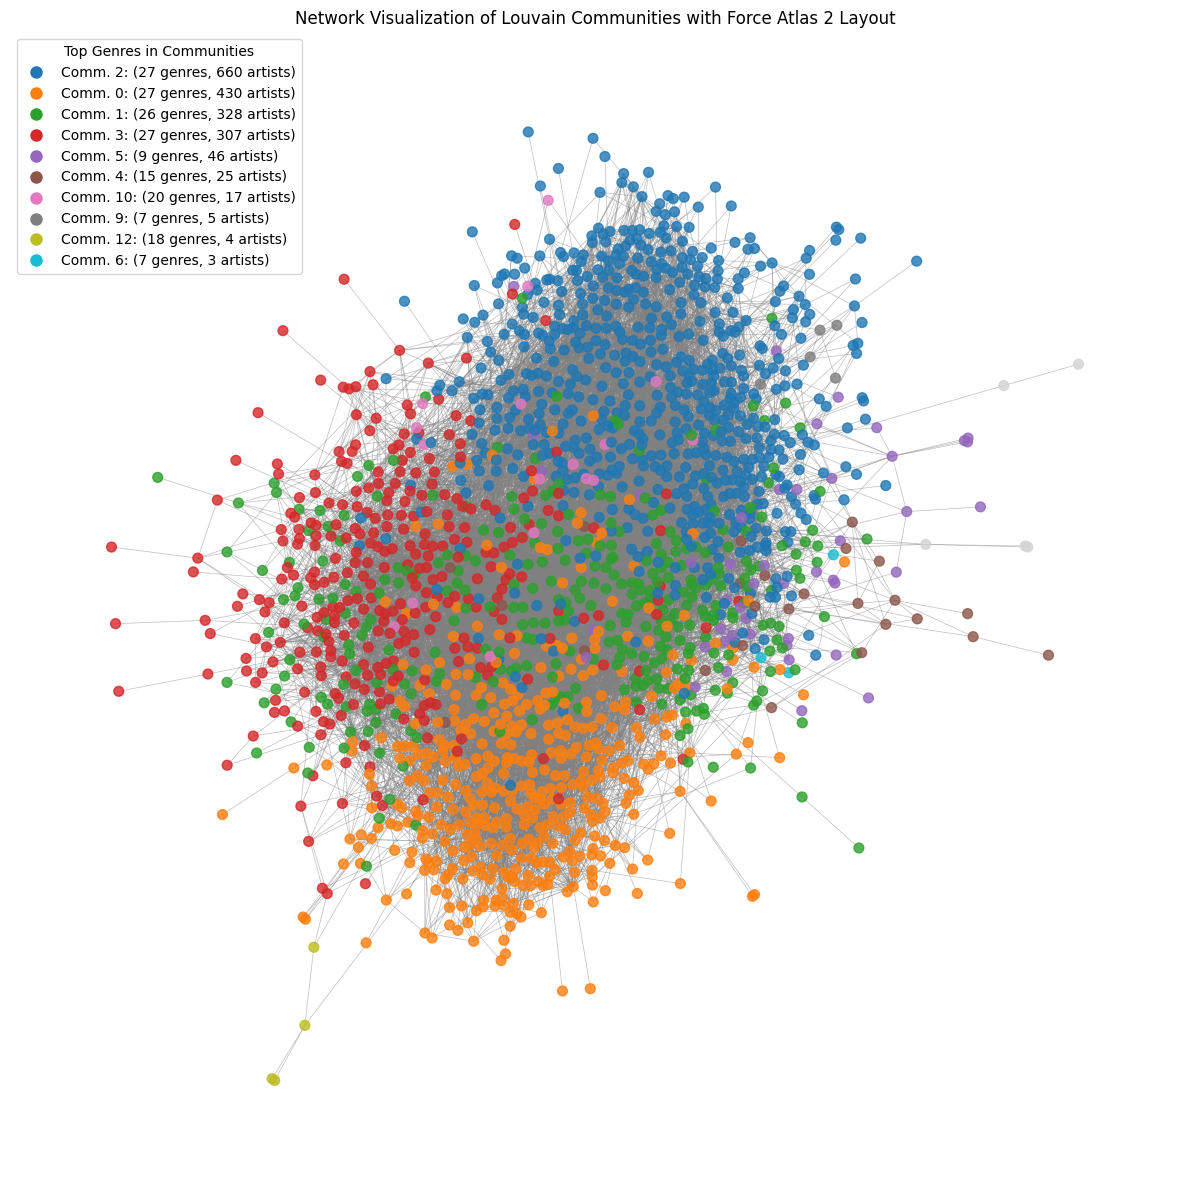

In [164]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import networkx as nx
from fa2_modified import ForceAtlas2
# remove loggging messages
import logging
logging.getLogger('fa2').setLevel(logging.WARNING)

# Get the list of communities from the partition
community_ids = set(partition_louvain.values())

# Count the size of each community
community_sizes = Counter(partition_louvain.values())

# Sort the communities by size in descending order
sorted_communities = [community for community, size in community_sizes.most_common()]

# Create a dictionary to store genre counts per community
community_genres = defaultdict(lambda: defaultdict(int))

# Loop over all nodes to count genres within each community
for node, community in partition_louvain.items():
    genres = artist_genres.get(node, [])
    for genre in genres:
        community_genres[community][genre] += 1

# Create a dictionary to store the top genre and number of genres for each community
community_labels = {}

for community, genre_counts in community_genres.items():
    # Find the most frequent genre in the community
    top_genre = max(genre_counts, key=genre_counts.get)
    # Count the number of unique genres in the community
    num_genres = len(genre_counts)
    num_artists = community_sizes[community]

    if num_genres > 1:
        # Create a label in the format: "Top Genre (X genres)"
        community_labels[community] = f"Comm. {community}: ({num_genres} genres, {num_artists} artists)"
    else:
        community_labels[community] = f"Comm. {community}: ({num_genres} genre, {num_artists} artists)"

# Assign colors to communities based on sorted order (by size)
# Let's color only the top 10 largest communities
num_top_communities = 10
top_communities = sorted_communities[:num_top_communities]

# Use a color map that supports many colors
colors = plt.get_cmap('tab10')  # Supports up to 10 distinct colors
color_map = {community_id: colors(i) for i, community_id in enumerate(top_communities)}

# Assign a neutral color for the smaller communities
neutral_color = 'lightgray'

# Color nodes based on community
node_colors = []
for node in G.nodes():
    community_id = partition_louvain[node]
    if community_id in top_communities:
        node_colors.append(color_map[community_id])
    else:
        node_colors.append(neutral_color)  # Neutral color for smaller communities

# Compute the layout using Force Atlas 2
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    linLogMode=False,  # NOT lin-lin mode
    adjustSizes=False,  # Prevent overlap (NOT)
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,

    # Log
    verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

# Draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, positions, node_size=50, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, positions, edge_color='gray', alpha=0.5, width=0.5)
plt.axis("off")

# Add a legend with the top genres and number of genres per community
legend_labels = [community_labels[community_id] for community_id in top_communities]
handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[i],
                      markerfacecolor=color_map[top_communities[i]], markersize=10) for i in range(len(top_communities))]

plt.legend(handles=handles, loc="best", title="Top Genres in Communities")
plt.title("Network Visualization of Louvain Communities with Force Atlas 2 Layout")
plt.tight_layout()
plt.show()


<span style="color:red">**Comment on the Results:**</span>
- The visualization shows that the network has distinct communities as detected by the Louvain algorithm.
- Nodes within the same community are closely connected.
- The coloring helps us see how the network divides into communities beyond the genre classifications.
- Comparing this to a plot colored by genres may show that genres are more spread out and less cohesive in terms of network structure.



---

# **Part 2: TF-IDF to Understand Genres and Communities**

**TF-IDF (Term Frequency-Inverse Document Frequency)** is a metric that helps evaluate the importance of a word in a document relative to a collection of documents, or corpus. It combines **Term Frequency (TF)**, which measures how frequently a word appears in a document, and **Inverse Document Frequency (IDF)**, which down-weights common words across the corpus to highlight distinctive terms. The TF-IDF score for a term is higher if it appears frequently in a specific document but is rare in other documents. This makes TF-IDF useful for identifying significant words that define the unique characteristics of genres and communities, as these high-score terms often reflect the themes, topics, or cultural elements central to each genre or community.

**In summary:**

- **Genres:** We can calculate TF-IDF scores for words within the texts of artists belonging to the same genre. This highlights words that are significant to that genre.
- **Communities:** Similarly, we can calculate TF-IDF scores for words within communities detected in the network to understand what characterizes each community.

### **Calculating and Visualizing TF-IDF for Genres and Communities**

To begin our analysis, we first need to build a rich text corpus that represents the thematic content associated with each artist, genre, and community within our network. The script accomplishes this by systematically fetching Wikipedia content for artists in our graph, focusing on the top 15 genres to capture the most influential groups. To ensure that the data is meaningful, the script prepares the text by removing irrelevant elements - such as common stop words and punctuation - and applies tokenization and text cleaning. This process leaves us with a refined collection of words that are specific to each artist and their genre. By aggregating these processed texts, we create a genre and community corpus that forms the foundation for deeper analysis in Parts 2 and 3, where we will use TF-IDF to highlight genre-specific themes and analyze sentiment to understand the emotional tone within different communities. The script can be seen in the appendix where we have commented on all the elements. 

In [ ]:
from networkx.readwrite import json_graph

# Load the Country Musician network with genres and content attributes
path = r"data\country_musician_graph_genres_content.json"
with open(path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Create a new graph from the JSON data
G = json_graph.node_link_graph(data)

print(f"Number of nodes & edges in the Country Music Network:")
print(f"- {G.number_of_nodes()} nodes")
print(f"- {G.number_of_edges()} edges")

# sample of 5 nodes
sample_nodes = list(G.nodes())[:2]
print(f"\nSample of 2 nodes:")
for node in sample_nodes:
    print(f"\n- {node}:")
    # loop over the attributes
    for key, value in G.nodes[node].items():
        if key == "content":
            # Print only the first 100 characters of the content
            print(f"  - {key}: {value[:100]}...")
        elif key == "word_count":
            # Print the first 5 words
            print(f"  - {key}: {list(value.items())[:10]}...")
        else:
            print(f"  - {key}: {value}")

Number of nodes & edges in the Country Music Network:
- 1830 nodes
- 14395 edges

Sample of 2 nodes:

- Red_Sovine:
  - length_of_content: 2604
  - genre: country
  - content: woodrow wilson red sovine july april american country music singer songwriter associated truckdrivin...
  - word_count: [('woodrow', 1), ('wilson', 1), ('red', 4), ('sovine', 22), ('july', 1), ('april', 2), ('american', 1), ('country', 7), ('music', 4), ('singer', 1)]...

- George_Jones:
  - length_of_content: 8384
  - genre: country
  - content: george glenn jones september april american country musician singer songwriter achieved internationa...
  - word_count: [('george', 22), ('glenn', 3), ('jones', 142), ('september', 2), ('april', 5), ('american', 1), ('country', 52), ('musician', 2), ('singer', 15), ('songwriter', 4)]...


### **Calculating and Visualizing TF-IDF for the Genres**

To understand the unique themes that define each genre, we will calculate **Term Frequency-Inverse Document Frequency (TF-IDF)** for the top 15 genres, focusing on the most prominent groups in our network.

In the following code, we will:
1. **Extract Content by Genre**: Collect the text content stored in each node, grouped by genre, focusing only on the top 15 genres.
2. **Compute Term Frequency (TF)**: Calculate the frequency of each word within each genre, using log normalization to reduce the impact of very common terms.
3. **Calculate Inverse Document Frequency (IDF)**: Determine how unique each word is across the top genres, down-weighting terms that appear frequently across genres.
4. **Calculate TF-IDF**: Combine TF and IDF to score the importance of each word in distinguishing genres.
5. **Visualize Top Words with Word Clouds**: Generate word clouds and a summary table to display the top 10 TF-IDF words for each genre, giving us a visual overview of the defining terms.

This process will help us identify the unique vocabulary that characterizes each genre, setting the stage for deeper genre and community analysis.

Top 10 TF-IDF words for each of the top 15 genres:


Word #1           Word #2  \
Musical Genre                                                
Country                 mandrell (17.04)    alaina (14.80)   
Americana                bingham (13.51)    erelli (11.92)   
Neotraditional Country     goans (10.68)  lovelesss (8.58)   
Rock And Roll                 rwb (9.85)     haleys (9.45)   
Bluegrass               trischka (10.04)     rowans (9.65)   
Folk                     kilcher (13.70)   matsson (11.92)   
Progressive Bluegrass       burch (5.94)     rushad (5.68)   
Alternative Country      heidorn (10.54)    tweedys (9.65)   
Country Rock               wetzel (9.20)    everlys (8.80)   
Rock                    bowersox (11.83)   nesmith (11.29)   
Pop                       bieber (13.67)  pussycat (12.01)   
Country Pop               wallen (10.05)   bradbery (8.80)   
Rockabilly               downing (10.82)     ozzie (10.68)   
Southern Rock               bice (14.44)   wilkeson (9.44)   
Country Music                ives (8.25)    haworth (7.56)   

                                   Word #3            Word #4  \
Musical Genre                                                   
Country                   wynettes (14.77)   mccreery (14.54)   
Americana                struthers (11.63)  hackensaw (10.04)   
Neotraditional Country        dunns (7.18)    wystrach (6.85)   
Rock And Roll              santiago (9.44)   guralnick (8.94)   
Bluegrass               threefinger (8.94)   auldridge (8.66)   
Folk                         klara (11.08)      hynes (10.82)   
Progressive Bluegrass     eggleston (5.68)      creeks (5.63)   
Alternative Country      primitives (9.20)  margherita (8.94)   
Country Rock               paoletta (8.66)      hatter (8.66)   
Rock                     claudette (11.08)  hambridge (10.54)   
Pop                       destinys (11.63)       lobo (10.95)   
Country Pop                  fargos (8.34)  lowenstein (7.98)   
Rockabilly                heatherly (8.94)  bebopalula (8.34)   
Southern Rock            rossington (8.66)     artimus (8.34)   
Country Music               bengals (7.56)       bixby (7.47)   

                                 Word #5             Word #6  \
Musical Genre                                                  
Country                    oslin (14.36)     pickler (14.29)   
Americana                 cooders (9.65)     binghams (9.65)   
Neotraditional Country      duddy (6.65)      haywire (6.46)   
Rock And Roll            cochrans (8.80)       comets (8.42)   
Bluegrass                  tuttle (8.66)     bernhard (8.34)   
Folk                       valdy (10.38)    guthries (10.13)   
Progressive Bluegrass     watkins (5.47)        thile (4.99)   
Alternative Country       foxtrot (8.34)     stirratt (7.98)   
Country Rock            skeletons (8.34)       bowles (8.34)   
Rock                     illsley (10.04)       dolenz (9.85)   
Pop                       lovato (10.34)  timberlake (10.27)   
Country Pop                   ell (7.60)        birza (7.56)   
Rockabilly                 poovey (7.98)       boppin (7.98)   
Southern Rock               bices (8.34)         zant (8.06)   
Country Music              drusky (7.18)      druskys (7.07)   

                                   Word #7             Word #8  \
Musical Genre                                                    
Country                    macneil (13.93)  pennington (13.88)   
Americana                   sickmen (9.20)       bunzow (8.94)   
Neotraditional Country      midland (5.97)       kostas (5.94)   
Rock And Roll                  myra (7.98)      boppers (7.98)   
Bluegrass                 rosenthal (7.98)        ickes (7.60)   
Folk                    huntingtons (9.85)        leahy (9.85)   
Progressive Bluegrass        waller (4.96)        cowan (4.81)   
Alternative Country          tweedy (7.70)       plebes (7.56)   
Country Rock                  pocos (8.34)      mcgrail (7.98)   
Rock                      canciones (9.44)       felder (

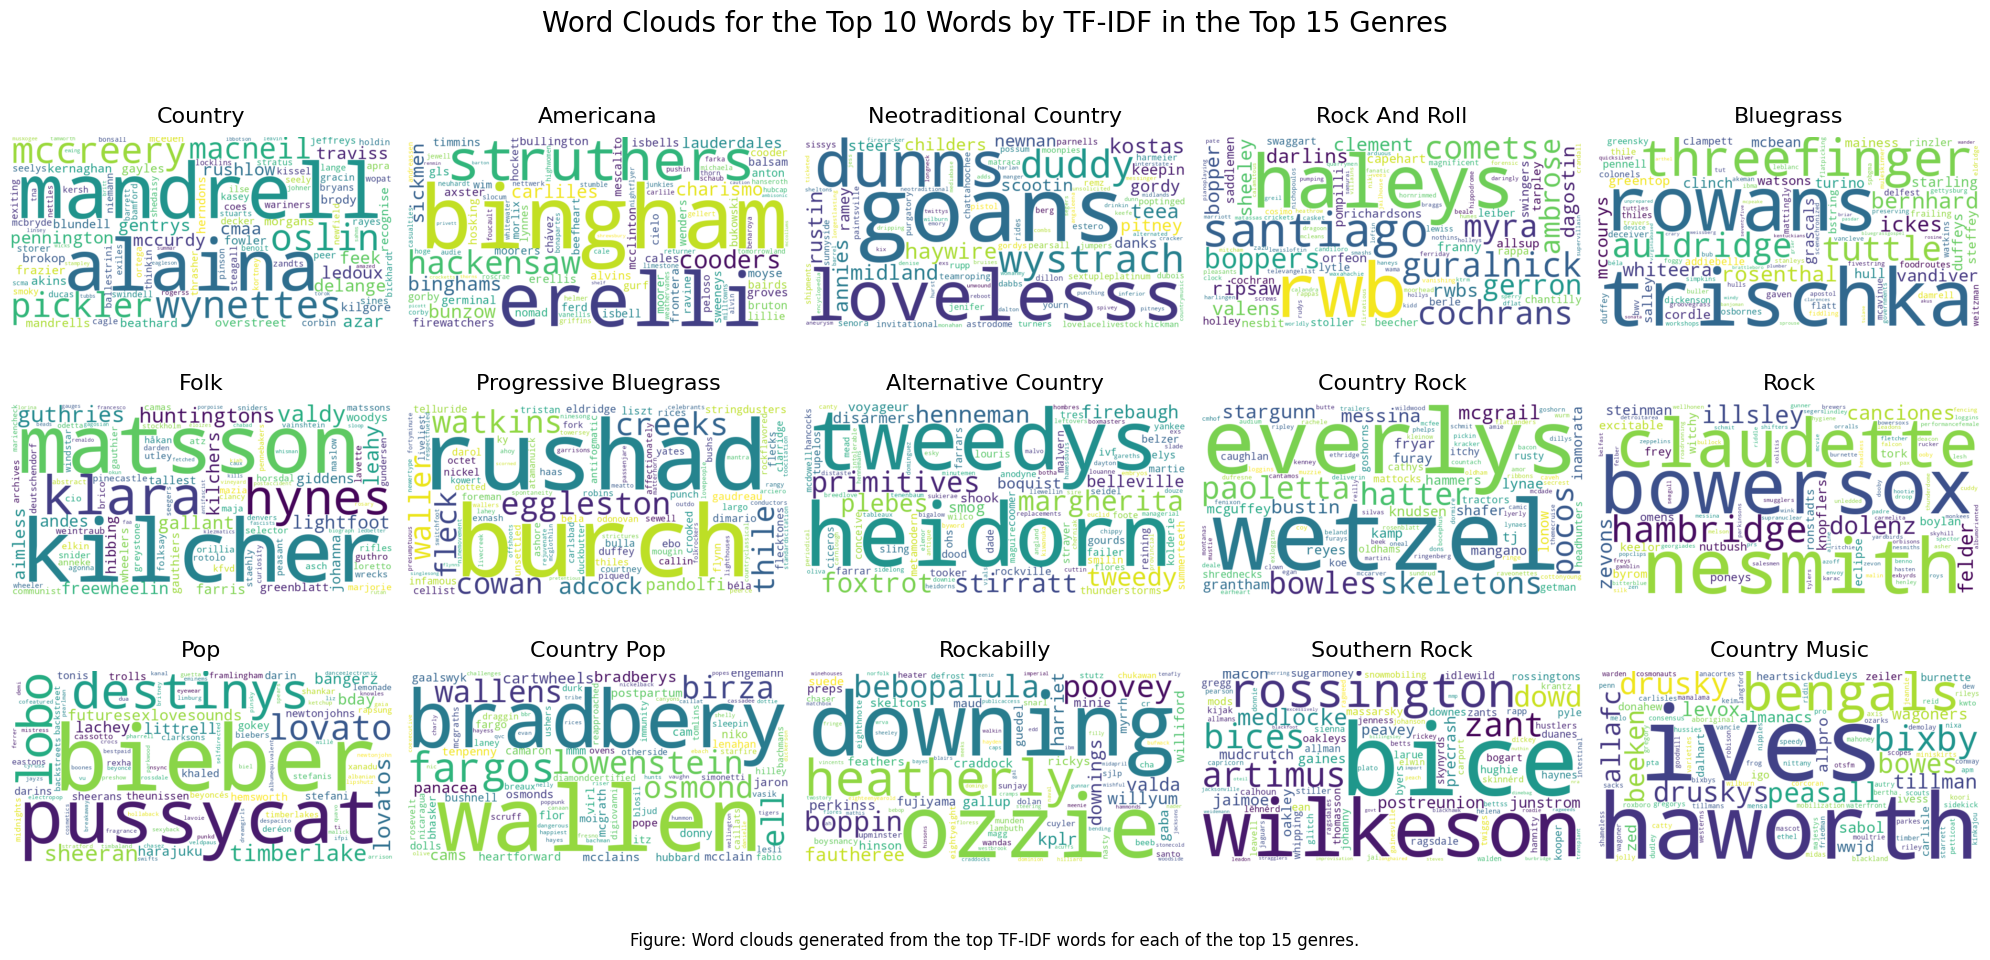

In [161]:
import math
from wordcloud import WordCloud

# Count the occurrences of each genre in the graph to identify the top 15
genre_counts = Counter(G.nodes[node].get('genre') for node in G.nodes if 'genre' in G.nodes[node])
top_15_genres = [genre for genre, _ in genre_counts.most_common(15)]

# Collect content by genre for only the top 15 genres
genres_texts = defaultdict(str)

for node in G.nodes():
    genre = G.nodes[node].get('genre')
    content = G.nodes[node].get('content', '')
    if genre in top_15_genres and content:
        genres_texts[genre] += " " + content  # Accumulate content for each genre

# Calculate TF for each of the top 15 genres
tf_by_genre = {}
for genre, text in genres_texts.items():
    word_counts = Counter(text.split())
    tf_by_genre[genre] = {word: 1 + math.log(count) for word, count in word_counts.items()}

# Calculate IDF across the top 15 genres
total_documents = len(genres_texts)
df_counts = Counter()
for text in genres_texts.values():
    unique_words = set(text.split())
    for word in unique_words:
        df_counts[word] += 1

idf = {word: math.log(total_documents / df_count) for word, df_count in df_counts.items()}

# Calculate TF-IDF for each of the top 15 genres
tfidf_by_genre = {}
for genre, tf_values in tf_by_genre.items():
    tfidf_by_genre[genre] = {word: tf * idf[word] for word, tf in tf_values.items()}

# Get top 10 TF-IDF words for each genre
top_words_by_genre = {}
for genre, tfidf in tfidf_by_genre.items():
    sorted_tfidf = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)
    top_words = sorted_tfidf[:10]
    top_words_by_genre[genre] = top_words

# Prepare data for the table
table_data = []
for genre, words in top_words_by_genre.items():
    words = [f"{word} ({score:.2f})" for word, score in words]
    table_data.append(words)

# Create a DataFrame with top TF-IDF words for each genre
df = pd.DataFrame(table_data, index=[genre.title() for genre in top_words_by_genre],
                  columns=[f"Word #{i+1}" for i in range(10)])

# Set the index name to "Musical Genre"
df.index.name = "Musical Genre"

# Display the DataFrame
print("Top 10 TF-IDF words for each of the top 15 genres:")
display(df)

# Create and display word clouds for each of the top 15 genres
num_genres = len(genres_texts)
num_cols = 5
num_rows = math.ceil(num_genres / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3))
axes = axes.flatten()

for idx, (genre, tfidf_scores) in enumerate(tfidf_by_genre.items()):
    ax = axes[idx]
    # Get the top TF-IDF scores for the word cloud
    top_tfidf_scores = dict(sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:100])
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False)
    wordcloud.generate_from_frequencies(top_tfidf_scores)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(genre.title(), fontsize=16, pad=10)

# Hide any empty subplots
for idx in range(len(tfidf_by_genre), len(axes)):
    axes[idx].axis('off')

# Add a main title
fig.suptitle('Word Clouds for the Top 10 Words by TF-IDF in the Top 15 Genres', fontsize=20, y=1.02)

# Add an in-figure caption
caption_text = 'Figure: Word clouds generated from the top TF-IDF words for each of the top 15 genres.'
plt.figtext(0.5, -0.02, caption_text, wrap=True, horizontalalignment='center', fontsize=12)
plt.tight_layout()
plt.show()

<span style="color:red">**Comment on the Results:**</span>

#### **Interpreting TF-IDF Results and Word Clouds**

The TF-IDF results reveal the most distinctive words in each genre, highlighting terms that are frequent within a genre but rare across others. A high TF-IDF score for a word suggests it is defining for that genre, capturing unique themes or stylistic elements.

- **Top Words Table**: Examine the top 10 TF-IDF words per genre to identify key themes or traits. For example, terms like "guitar" or "blues" may signal musical style, while specific names or terms might indicate cultural influences unique to that genre.
- **Word Clouds**: The word clouds provide a quick visual snapshot of each genre's defining vocabulary. Larger words represent terms with higher TF-IDF scores, indicating greater importance in distinguishing that genre. Comparing clouds can help spot both unique and overlapping terms, showing genre boundaries or connections.

#### **Key Observations**

- **Genre-Specific Language**: Note if the highlighted terms match expectations for each genre, or if there are surprising terms suggesting lesser-known traits.
- **Cross-Genre Patterns**: Look for terms that appear across multiple genres, as these can indicate shared influences or thematic overlaps, potentially hinting at community links within the network.
  
Overall, these TF-IDF scores and word clouds help us understand the distinctive vocabulary of each genre, offering insights into how genres and communities are structured and connected.


<span style="color:red">**Perhaps we should split TF.IDF metrics (df) and visuals into two seperate cells?**</span>

### **Calculate and Visualize TF-IDF for Communities**

To explore the unique vocabulary that defines each structural community within the network, we will calculate **TF-IDF** scores for words associated with each community. This process highlights terms that are significant within individual communities and less common across others, allowing us to understand the unique themes or characteristics that bind each community together.

In the following steps, we will:
1. **Aggregate Text by Community**: Combine the cleaned text content for all artists within each community, creating a single text corpus for each community.
2. **Compute Term Frequency (TF)**: For each community, calculate the frequency of each word, with log normalization applied to reduce the impact of highly frequent terms within the community.
3. **Calculate Inverse Document Frequency (IDF)**: Determine how unique each word is across all communities, giving less weight to words that appear frequently across multiple communities.
4. **Calculate TF-IDF**: Use TF and IDF to score words based on their ability to distinguish one community from others.
5. **Visualize Top Words with Word Clouds**: Generate word clouds and a summary table to display the top 10 TF-IDF words for each community, providing a visual representation of the defining terms.

This analysis will help us identify community-specific vocabulary, revealing the unique language, themes, or stylistic elements that characterize each community in the network.

Top 10 TF-IDF Words by Community:


Word #1             Word #2              Word #3  \
Community 1      comets (9.43)      locklin (8.84)          como (8.81)   
Community 2      vestal (8.16)    struthers (7.70)        exiles (7.49)   
Community 3     lovato (11.54)    bergling (10.34)         diplo (9.67)   
Community 4         ccr (9.24)         azar (8.84)        tweedy (8.56)   
Community 5    blundell (8.69)  cassardaley (7.63)         beccy (6.87)   
Community 6     stellas (6.24)   yellowbird (6.09)        johner (5.47)   
Community 7    stallcup (3.76)      mcguinn (3.19)          urie (3.03)   
Community 8     pistols (3.38)    wilkinson (3.30)    wilkinsons (2.97)   
Community 10  pritchett (4.58)      farrell (4.08)    pritchetts (3.03)   
Community 11       bice (9.55)     wystrach (6.87)         duddy (6.76)   
Community 12    benward (6.09)     jeoffrey (4.28)  firecrackers (3.76)   
Community 13       roba (5.52)    gilliland (4.68)        phagan (4.28)   

                        Word #4            Word #5              Word #6  \
Community 1       gayles (8.36)      laines (8.31)         autry (8.27)   
Community 2       duffey (7.49)    gaudreau (7.41)        diffie (7.37)   
Community 3     mccreery (9.62)      bieber (9.46)         rexha (9.35)   
Community 4       wilcos (7.89)     matsson (7.89)        erelli (7.89)   
Community 5    kernaghan (6.72)       jetty (6.52)        storer (6.39)   
Community 6     mccorvey (5.47)        scma (5.39)       mcgrail (5.28)   
Community 7      delious (3.03)     rennick (3.03)           vfr (2.91)   
Community 8       amanda (2.36)  belleville (2.31)    downsizing (1.79)   
Community 10  commandant (2.35)    mandarin (2.35)      farrells (2.31)   
Community 11    wilkeson (6.24)     artimus (5.52)         bices (5.52)   
Community 12         ccm (1.86)        curb (1.81)  actorsingers (1.79)   
Community 13    arkansaw (3.76)      gooden (3.76)      brockman (3.62)   

                        Word #7                Word #8                Word #9  \
Community 1        darin (8.17)          darins (8.16)       goldsboro (7.83)   
Community 2        oslin (7.33)        ibbotson (7.33)           kohrs (7.33)   
Community 3   backstreet (9.35)         mccurdy (9.13)         kilcher (9.07)   
Community 4      worsnop (7.89)          astral (7.76)          keelor (7.76)   
Community 5     simmonds (6.39)        jeffreys (6.35)     williamsons (6.24)   
Community 6    marylynne (5.28)         brokops (5.28)           alves (5.04)   
Community 7         rudy (2.09)           lance (2.09)            kplx (1.79)   
Community 8       menial (1.79)         devries (1.79)          weekes (1.79)   
Community 10    mcintosh (2.09)              bc (1.84)  actresssingers (1.79)   
Community 11        zant (5.48)          jaimoe (5.47)     postreunion (5.28)   
Community 12     sareece (1.79)  scholarathlete (1.79)       sonfather (1.79)   
Community 13     fiddlin (3.38)            okeh (3.38)          sallie (3.31)   

                     Word #10  
Community 1     wakely (7.70)  
Community 2   murpheys (7.25)  
Community 3    lovatos (8.84)  
Community 4     farrar (7.74)  
Community 5     albeck (6.09)  
Community 6     bustin (5.00)  
Community 7     jerimy (1.79)  
Community 8     quinte (1.79)  
Community 10   cadance (1.79)  
Community 11  medlocke (5.00)  
Community 12     kenda (1.79)  
Community 13  talmadge (3.31)

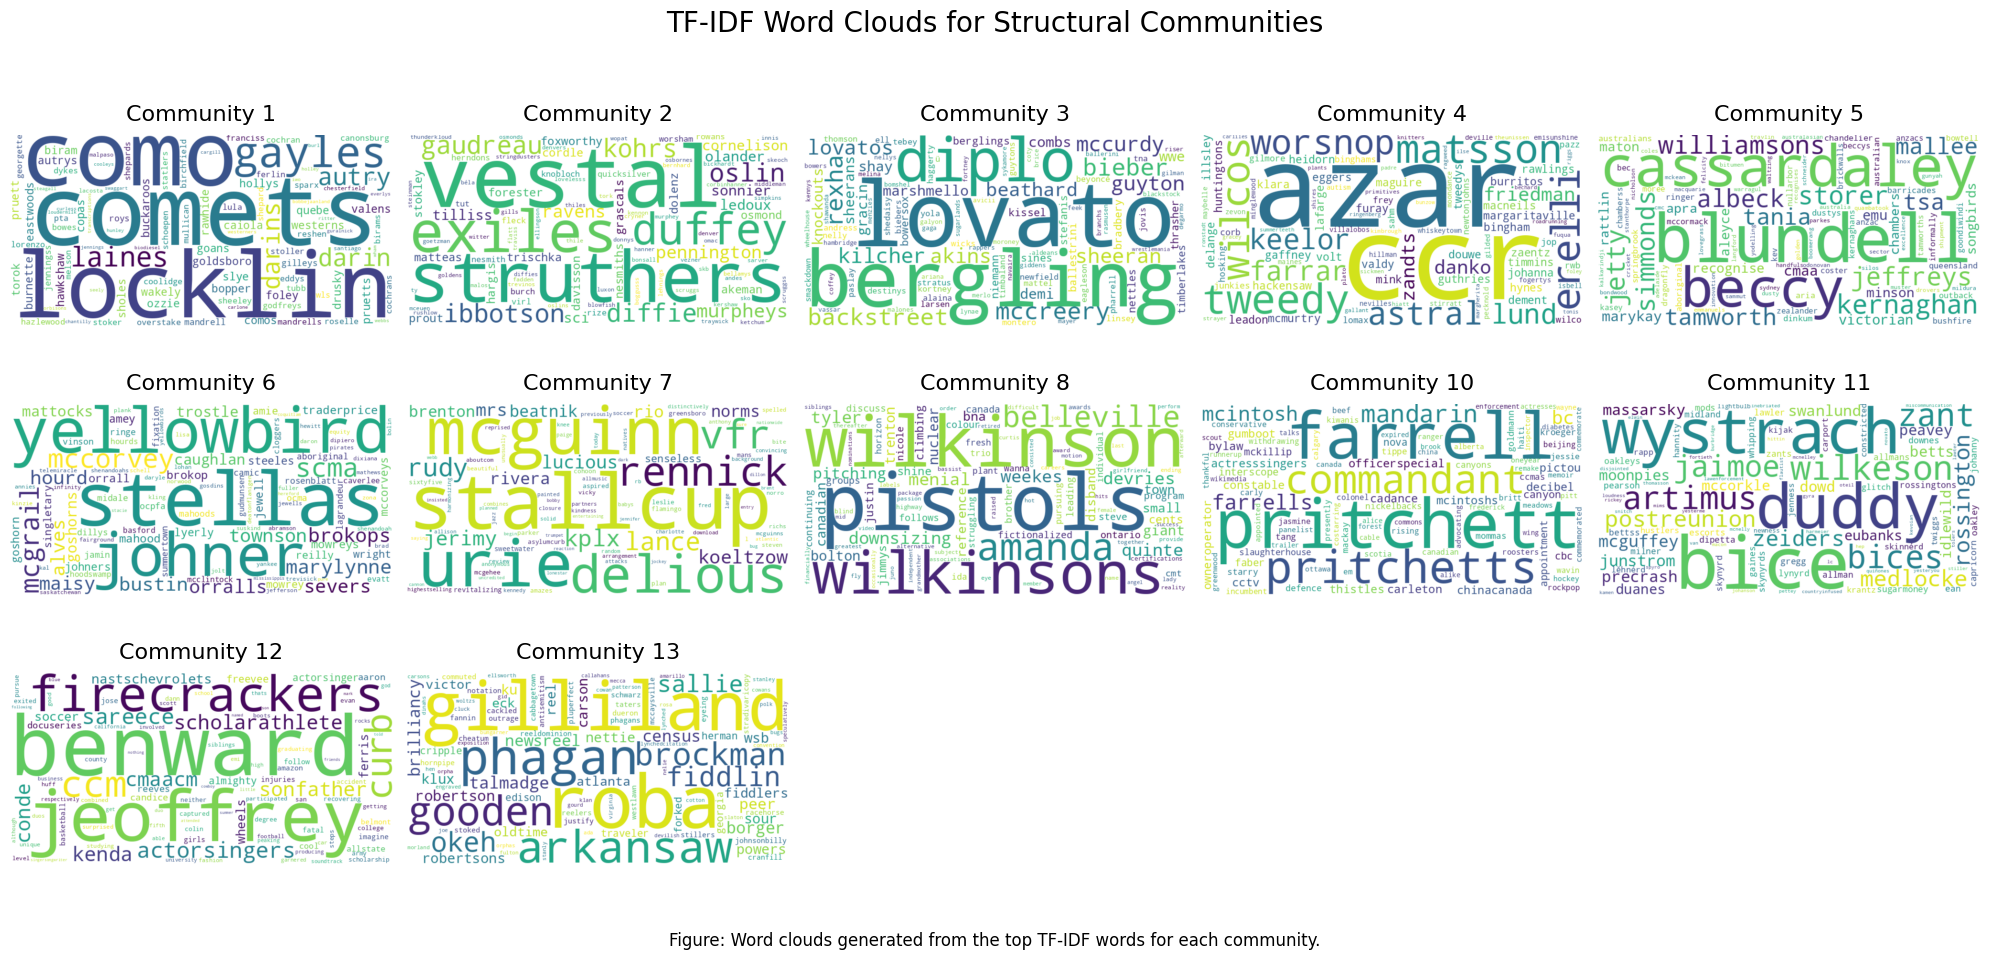

In [162]:
# Step 1: Aggregate cleaned text by community
community_texts = defaultdict(str)
for artist, community in partition_louvain.items():
    try:
        if 'content' in G.nodes[artist]:  # Check if 'content' exists for the artist node
            community_texts[community] += G.nodes[artist]['content'] + " "
    except KeyError:
        print(f"Node {artist} is missing content information")

# Step 2: Calculate TF for each community
tf_by_community = {}
for community, text in community_texts.items():
    word_counts = Counter(text.split())
    tf_by_community[community] = {word: 1 + math.log(count) for word, count in word_counts.items()}

# Step 3: Calculate IDF across all communities
total_communities = len(community_texts)
df_counts = Counter()
for text in community_texts.values():
    unique_words = set(text.split())
    for word in unique_words:
        df_counts[word] += 1

idf = {word: math.log(total_communities / (df_count + 1)) for word, df_count in df_counts.items()}  # Adding 1 to avoid zero division

# Step 4: Calculate TF-IDF for each community
tfidf_by_community = {}
for community, tf_values in tf_by_community.items():
    tfidf_by_community[community] = {word: tf * idf[word] for word, tf in tf_values.items()}

# Step 5: Get top 10 TF-IDF words for each community
top_words_by_community = {}
table_data = []

for community, tfidf in tfidf_by_community.items():
    sorted_tfidf = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)
    top_words = sorted_tfidf[:10]
    top_words_by_community[community] = top_words
    words = [f"{word} ({score:.2f})" for word, score in top_words]
    table_data.append(words)

# Create a DataFrame with the top TF-IDF words for each community
df = pd.DataFrame(table_data, index=[f"Community {c+1}" for c in top_words_by_community],
                  columns=[f"Word #{i+1}" for i in range(10)])

# Display the DataFrame
print("Top 10 TF-IDF Words by Community:")
display(df)

# Step 6: Create and display word clouds for each community
num_communities = len(community_texts)
num_cols = 5
num_rows = math.ceil(num_communities / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3))
axes = axes.flatten()

for idx, (community, tfidf_scores) in enumerate(tfidf_by_community.items()):
    ax = axes[idx]
    # Get the top TF-IDF scores for the word cloud
    top_tfidf_scores = dict(sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:100])
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False)
    wordcloud.generate_from_frequencies(top_tfidf_scores)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Community {community+1}", fontsize=16, pad=10)

# Hide any empty subplots
for idx in range(len(tfidf_by_community), len(axes)):
    axes[idx].axis('off')

# Add a main title and caption
fig.suptitle('TF-IDF Word Clouds for Structural Communities', fontsize=20, y=1.02)
caption_text = 'Figure: Word clouds generated from the top TF-IDF words for each community.'
plt.figtext(0.5, -0.02, caption_text, wrap=True, horizontalalignment='center', fontsize=12)
plt.tight_layout()
plt.show()

### **Analyzing Differences and Similarities Between Genre and Community Word Clouds Using Matrix** $\mathbf{D}$

The matrix $D $ reveals node overlap between specific genres and structural communities, with higher values indicating stronger alignment. For example:
- **Country** (genre) aligns most with **Community C3**, indicating that many artists identified with the "Country" genre are also part of this structural community.
- **Folk** and **Rock** align most with **Community C4**, suggesting that artists in these genres frequently appear together within this community, hinting at shared influences or collaborative networks.

#### **Differences in Word Clouds for Genres and Communities**

1. **Genre-Specific Language**: The genre word clouds capture vocabulary uniquely associated with each genre, including artist names, traditional themes, and stylistic elements that define each genre’s cultural identity.
   - **Country**: The genre word cloud for "Country" highlights artist names like **Mandrell**, **McCreery**, and **Alaina**. These artists are prominent within country music, representing the traditional and mainstream country influences ([Barbara Mandrell](https://en.wikipedia.org/wiki/Barbara_Mandrell)).
   - **Folk**: The **Folk** word cloud includes terms like **Guthries** and **Valdy**, pointing to iconic folk artists and themes of storytelling and acoustic music ([Arlo Guthrie](https://en.wikipedia.org/wiki/Arlo_Guthrie)).
   - **Rock**: The **Rock** word cloud shows names such as **Bowersox** and **Nesmith**, reflecting artists who are well-known within rock and its subgenres ([Michael Nesmith](https://en.wikipedia.org/wiki/Michael_Nesmith)).

   These genre word clouds highlight distinctive terms that define the genre, focusing heavily on artist names and genre-specific language.

2. **Community-Based Themes**: Community word clouds represent a mix of artists and terms from various genres, reflecting broader groupings based on structural connections rather than strict genre lines.
   - **Community 3**: This community word cloud includes terms like **Lovato**, **Bieber**, and **diplomats**, suggesting a mix of pop and crossover artists with broad appeal. This aligns with the high overlap between **Pop** and **Community C3** in $D $ ([Demi Lovato](https://en.wikipedia.org/wiki/Demi_Lovato), [Justin Bieber](https://en.wikipedia.org/wiki/Justin_Bieber)).
   - **Community 4**: Terms like **Azar**, **Wilcos**, and **CCR** (Creedence Clearwater Revival) show a blend of Southern rock, Americana, and alternative country influences, aligning with **Rock** and **Country Rock** genres ([CCR](https://en.wikipedia.org/wiki/Creedence_Clearwater_Revival)) ([Azar](https://en.wikipedia.org/wiki/Steve_Azar)). This mix reflects cross-genre connections among artists who share thematic or stylistic similarities, even if they belong to different genres.

   Unlike the genre word clouds, which focus on distinct musical styles, community word clouds capture broader connections, often blending genres through shared influences and collaborative networks.

3. **Overlaps and Unique Themes**:
   - The alignment of **Country** with **Community C3** in $D $ explains why both word clouds feature words like 'McCreery. The community’s structure supports a concentration of country themes, mirroring the genre's own language.
   - **Community C4** bridges **Folk** and **Rock** genres, as evidenced by shared terms like **CCR** and **Wilcos**. This shows that communities can capture connections that go beyond individual genres, linking artists with shared influences across genres.
   - Community word clouds reveal broader, cross-genre influences, while genre word clouds are more focused on unique stylistic identities.

**In summary:**

The matrix $D $ helps clarify why genre word clouds highlight specific musical identities, while community word clouds reveal cross-genre connections. Genre word clouds emphasize artist names and genre-defining terms, whereas community word clouds reflect broader themes based on structural relationships within the network.


---

# **Part 3: Sentiment of the Artists and Communities**

We will now turn towards sentiment analysis of the artist's wikipeadia pages. We will continue with out graph G that containing the wikipedia content node attribute. Please refer to the appendix so see how we processed the graph.

## **Calculating Sentiment of Artist Pages**

We will calculate the sentiment of each artist's Wikipedia page using the LabMT sentiment lexicon.

The **LabMT** (Language Assessment by Mechanical Turk) wordlist contains around 10,000 of the most common English words, each rated for emotional valence on a happiness scale from 1 (negative) to 9 (positive). Generated using crowdsourced ratings from Amazon Mechanical Turk, the list averages these scores to quantify public perception of each word's emotional content. This dataset, used in sentiment analysis applications like tracking happiness on Twitter, provides a standardized approach to measure sentiment in text. 

Dodds, P. S., Harris, K. D., Kloumann, I. M., Bliss, C. A., & Danforth, C. M. (2011). Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter. *PLoS ONE*, 6(12), e26752. [Link](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752)


### **Preparing the Sentiment Lexicon**
We downloaded the LabMT sentinemt lexicon and prepare for sentiment analysis. The sentinment lexicon contains 9 keys:
- 'word'
- 'happiness_rank'
- 'happiness_average',
- 'happiness_standard_deviation'
- 'twitter_rank'
- 'google_rank',
- 'nyt_rank'
- 'lyrics_rank'

For the purpose of this exercise we will only be using `word` and `happiness_average`.

In [ ]:
# Load the LabMT word list
file_path = r"data\LabMT_wordlist.txt"

# Load the data
df = pd.read_csv(file_path, sep='\s+', skiprows=2)

# print number of words
print(f"Number of words in the LabMT word list: {len(df['word'])}")
print(f"Sample of 5 words:")
print(df.head())

# Create a dictionary mapping words to their happiness scores
labmt_lexicon = dict(zip(df['word'], df['happiness_average']))

Number of words in the LabMT word list: 10222
Sample of 5 words:
        word  happiness_rank  happiness_average  happiness_standard_deviation  \
0   laughter               1               8.50                        0.9313   
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

  twitter_rank google_rank nyt_rank lyrics_rank  
0         3600          --       --        1728  
1         1853        2458       --        1230  
2           25         317      328          23  
3           65        1372     1313         375  
4         3334        3542       --        2332  


### **Function to Calculate Sentiment**

 Each artist's page is tokenized, and each word’s happiness score is retrieved from the LabMT lexicon. The average score of these words gives a sentiment score for the page. This process helps quantify the general emotional tone of each artist's Wikipedia content. We default to a neutral score of 5 for tokens that are not in the lexicon. Five is considered neutral based on the authors of the LabMT paper.

In [ ]:
def calculate_sentiment(tokens):
    # Default to neutral score of 5.0 if the token is not found in the lexicon
    sentiments = [labmt_lexicon.get(word, 5.0) for word in tokens]  
    if sentiments:
        return np.mean(sentiments)
    else:
        return 5.0

### **Calculating Sentiment for Each Artist**

The sentiment scores for each artist are computed and stored as node attributes in the graph:

In [105]:
from tqdm import tqdm

# Calculate sentiment for each node
sentiments = {}

for node in tqdm(G.nodes(), desc='Calculating sentiment for nodes'):
    content = G.nodes[node].get('content', '')
    tokens = content.split()
    # Calculate sentiment
    sentiment = calculate_sentiment(tokens)
    # Store sentiment as a node attribute
    G.nodes[node]['sentiment'] = sentiment
    sentiments[node] = sentiment


Calculating sentiment for nodes: 100%|██████████| 1830/1830 [00:00<00:00, 6639.27it/s]


### **Statistical Analysis of Sentiment**

Once we have the sentiment scores, we calculate descriptive statistics to understand the overall sentiment distribution:

In [106]:
import statistics

# Extract sentiment values
sentiment_values = list(sentiments.values())

# Calculate statistics
mean_sentiment = np.mean(sentiment_values)
median_sentiment = np.median(sentiment_values)
variance_sentiment = np.var(sentiment_values)
percentile_25 = np.percentile(sentiment_values, 25)
percentile_75 = np.percentile(sentiment_values, 75)

print(f"Average Sentiment: {mean_sentiment:.4f}")
print(f"Median Sentiment: {median_sentiment:.4f}")
print(f"Variance of Sentiment: {variance_sentiment:.4f}")
print(f"25th Percentile: {percentile_25:.4f}")
print(f"75th Percentile: {percentile_75:.4f}")


Average Sentiment: 5.6965
Median Sentiment: 5.6923
Variance of Sentiment: 0.0101
25th Percentile: 5.6299
75th Percentile: 5.7558


- **Mean** and **Median Sentiment**: Around 5.70, indicating a slightly positive general sentiment across the artists.
- **Variance** and **Percentiles**: These help us gauge the spread and skewness of sentiment scores among artists. We see that interquantile range is actually above neutral with a quite low variance.

### **Visualizing Sentiment Distribution**

We construct a histogram so visualize the distribution of artist sentiment scores along with the summary statistics:

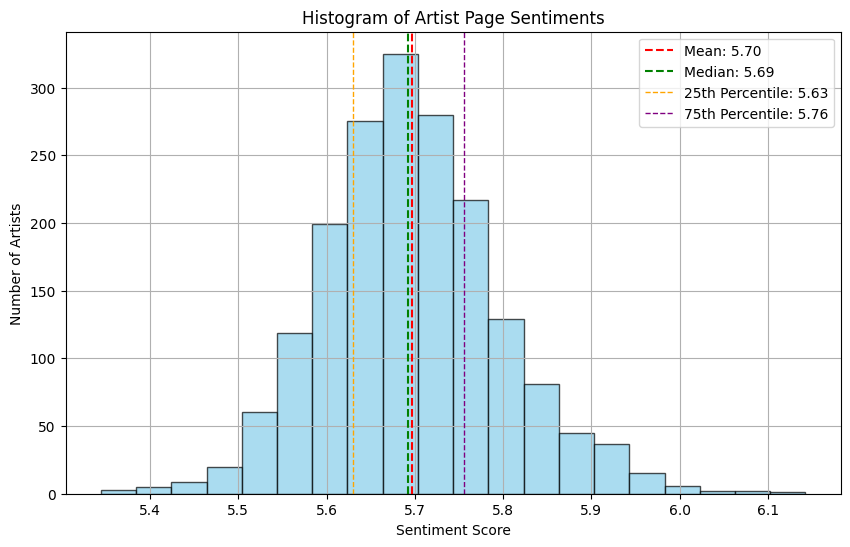

In [146]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(sentiment_values, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Add mean and median lines
plt.axvline(mean_sentiment, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_sentiment:.2f}')
plt.axvline(median_sentiment, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_sentiment:.2f}')

# Add percentile lines
plt.axvline(percentile_25, color='orange', linestyle='dashed', linewidth=1, label=f'25th Percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='purple', linestyle='dashed', linewidth=1, label=f'75th Percentile: {percentile_75:.2f}')

plt.title('Histogram of Artist Page Sentiments')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Artists')
plt.legend()
plt.grid(True)
plt.show()


The sentiment scores are mostly clustered around the mean, with a slight positive skew. Lines representing mean, median, and 25th/75th percentiles provide reference points for understanding where most artists fall within the sentiment range.

### **Happiest and Saddest Artists**

We sort the sentiment scores to identify the happiest and saddest artists based on their Wikipedia content:

In [115]:
# Sort the sentiments
sorted_sentiments = sorted(sentiments.items(), key=lambda x: x[1])

# 10 Saddest Artists
saddest_artists = sorted_sentiments[:10]
print("10 Saddest Artists:\n")
for artist, sentiment in saddest_artists:
    print(f"{artist.replace('_',' ')}: {sentiment:.4f}")

# 10 Happiest Artists
happiest_artists = sorted_sentiments[-10:]
print("\n10 Happiest Artists:\n")
for artist, sentiment in reversed(happiest_artists):
    print(f"{artist.replace('_',' ')}: {sentiment:.4f}")


10 Saddest Artists:

Mindy McCready: 5.3443
Spade Cooley: 5.3790
Redneck Souljers: 5.3819
Carl Belew: 5.3907
Giant Sand: 5.3991
Johnny Van Zant: 5.4104
Joey Feek: 5.4128
S-K-O: 5.4204
Tex Williams: 5.4263
Ira Louvin: 5.4295

10 Happiest Artists:

Doc Walker: 6.1426
McAlister Kemp: 6.0803
McKenna Faith: 6.0641
Tara Lyn Hart: 6.0281
Aleyce Simmonds: 6.0256
Raquel Cole: 6.0166
The Peasall Sisters: 6.0077
Jessie Farrell: 6.0052
CB30: 5.9942
The Sunny Cowgirls: 5.9892



<span style="color:red">**Findings: DISCUSS FURTHER AND FIND GOOD SOURCES**</span>

- The sentiment scores provide a quantitative measure of the emotional content in each artist's Wikipedia page.
- The distribution shows most pages have sentiment scores around the neutral to slightly positive range.
- Artists with the lowest sentiment scores may have pages that discuss tragedies, controversies, or darker themes.
- Conversely, artists with the highest sentiment scores may have pages that focus on positive achievements and uplifting content.

## **Community Sentiment Distribution**

### **Calculating Community-Level Sentiment**

To analyze sentiment at the community level, we calculate the average sentiment score for the three most connected (highest-degree) artists within each community.

This approach provides a representative sentiment score for each community by focusing on influential or central members:

In [129]:
# Initialize dictionary to store sentiments per community
community_sentiments = defaultdict(list)

# remove nodes without sentiment
nodes_to_remove = [node for node in partition_louvain if node not in sentiments]
for node in nodes_to_remove:
    partition_louvain.pop(node)


# Get the degrees of nodes
degrees = dict(G.degree())

# Initialize dictionary to store community members
community_members = defaultdict(list)

# Group nodes by community
for node, community in partition_louvain.items():
    community_members[community].append(node)

# Get top 3 nodes by degree in each community
largest_communities = {}
for community, members in community_members.items():
    # Sort members by degree
    sorted_members = sorted(members, key=lambda x: degrees[x], reverse=True)
    top_members = sorted_members[:3]
    largest_communities[community] = top_members

# Calculate average sentiment per community
average_community_sentiment = {}
for community, members in community_members.items():
    community_sentiments[community] = [sentiments[member] for member in members]
    average_sentiment = np.mean(community_sentiments[community])
    average_community_sentiment[community] = average_sentiment

# Top 10 communities by average sentiment (defined by the top 3 nodes)
top_communities = sorted(average_community_sentiment, key=average_community_sentiment.get, reverse=True)[:10]
print(f"Top 10 communities by average sentiment:")
for community_id in top_communities:
    members = largest_communities[community_id]
    # remove "_" from artist names
    members = [member.replace('_', ' ') for member in members]

    avg_sentiment = average_community_sentiment[community_id]
    print(f"Community {community_id}: {avg_sentiment:.4f} (Top 3 nodes: {', '.join(members)})")

Top 10 communities by average sentiment:
Community 9: 5.8640 (Top 3 nodes: George Canyon, Aaron Pritchett, One More Girl)
Community 7: 5.8509 (Top 3 nodes: The Wilkinsons, Small Town Pistols, Amanda Wilkinson)
Community 4: 5.8425 (Top 3 nodes: Kasey Chambers, Beccy Cole, Tommy Emmanuel)
Community 5: 5.7439 (Top 3 nodes: Curtis Wright, Robert Ellis Orrall, Pure Prairie League)
Community 2: 5.7211 (Top 3 nodes: Dolly Parton, Reba McEntire, George Strait)
Community 6: 5.7025 (Top 3 nodes: Mark McGuinn, South 65, Rio Grand)
Community 11: 5.7014 (Top 3 nodes: Blue County (music group), Aaron Benward)
Community 1: 5.6899 (Top 3 nodes: Vince Gill, Patty Loveless, Randy Travis)
Community 3: 5.6873 (Top 3 nodes: Emmylou Harris, Bob Dylan, Dwight Yoakam)
Community 0: 5.6575 (Top 3 nodes: Willie Nelson, Johnny Cash, Merle Haggard)


### **Happiest and Saddest Communities**

By averaging the sentiment of the top artists in each community, we identify the communities with the highest and lowest average sentiment:

In [142]:
# Sort communities by average sentiment
sorted_communities = sorted(average_community_sentiment.items(), key=lambda x: x[1])

# Saddest Communities
print("Three Saddest Communities:\n")
for community, sentiment in sorted_communities[:3]:
    print(f"Community {community} ({largest_communities[community]}):\n\tAverage Sentiment = {sentiment:.4f}\n")

# Happiest Communities
print("\nThree Happiest Communities:\n")
for community, sentiment in sorted_communities[-3:]:
    print(f"Community {community} ({largest_communities[community]}):\n\tAverage Sentiment = {sentiment:.4f}\n")

Three Saddest Communities:

Community 12 (["Fiddlin'_John_Carson", 'Cowan_Powers_and_his_Family_Band', 'Eck_Robertson']):
	Average Sentiment = 5.6170

Community 10 (['Lynyrd_Skynyrd', 'Gary_Stewart_(singer)', 'Allman_Brothers_Band']):
	Average Sentiment = 5.6172

Community 0 (['Willie_Nelson', 'Johnny_Cash', 'Merle_Haggard']):
	Average Sentiment = 5.6575


Three Happiest Communities:

Community 4 (['Kasey_Chambers', 'Beccy_Cole', 'Tommy_Emmanuel']):
	Average Sentiment = 5.8425

Community 7 (['The_Wilkinsons', 'Small_Town_Pistols', 'Amanda_Wilkinson']):
	Average Sentiment = 5.8509

Community 9 (['George_Canyon', 'Aaron_Pritchett', 'One_More_Girl']):
	Average Sentiment = 5.8640



Looking at the average sentiment for the 3 happiest & saddest communities it appears that there's not much of a difference. However, although they might be numerically close across thousands of tokens where many of them are neutral. There's a stark difference between the sentiment of the wikipedia pages.

Let's delve into some of these happiest and saddest artist. Let's start by investigating why Lynyrd Skynyrd might have one of the lowest average sentiments.

In [153]:
# Get the content of the node
content_sad = G.nodes['Lynyrd_Skynyrd']['content']

# Tokenize the content
tokens = content_sad.split()

# Calculate the sentiment of the content
sentiment = calculate_sentiment(tokens)
print(f"Sentiment of the content: {sentiment:.4f}")

# Calculate the sentiment of each token
token_sentiments = {token: labmt_lexicon.get(token, 5.0) for token in tokens}

# Sort the tokens by sentiment
sorted_tokens = sorted(token_sentiments.items(), key=lambda x: x[1], reverse=False)

# Display the top 10 tokens by sentiment
print("Top 10 tokens by lowest sentiment:")
for token, sentiment in sorted_tokens[:10]:
    print(f"{token}: {sentiment:.4f}")

Sentiment of the content: 5.4901
Top 10 tokens by lowest sentiment:
death: 1.5400
cancer: 1.5400
died: 1.5600
killed: 1.5600
arrested: 1.6400
killing: 1.7000
jail: 1.7600
abuse: 1.8800
dead: 2.0000
disease: 2.0000


As evident by the tokens present on the wikipedia page of Lynyrd Skynyrd it is no surprise that they place low on the sentiment score.

Let's investigate the diametrically opposite by looking at the tokens with high sentiments which contribute to the higher average sentiment of Aaron Pritchett:

In [157]:
content_kinda_happy = G.nodes['Aaron_Pritchett']['content']

# Tokenize the content
tokens = content_kinda_happy.split()

# Calculate the sentiment of the content
sentiment = calculate_sentiment(tokens)
print(f"Sentiment of the content: {sentiment:.4f}")

# Calculate the sentiment of each token
token_sentiments = {token: labmt_lexicon.get(token, 5.0) for token in tokens}

# Sort the tokens by sentiment
sorted_tokens = sorted(token_sentiments.items(), key=lambda x: x[1], reverse=True)

# Display the top 10 tokens by sentiment
print("Top 10 tokens by sentiment:")
for token, sentiment in sorted_tokens[:10]:
    print(f"{token}: {sentiment:.4f}")

Sentiment of the content: 5.8020
Top 10 tokens by sentiment:
love: 8.4200
music: 8.0200
thankful: 7.4400
cash: 7.4200
money: 7.3000
greatest: 7.2600
star: 7.2200
awards: 7.1800
playing: 7.1400
better: 7.0000


As we see from the top 10 tokens by sentiment score - such as "love", "music", "thankful" and "awards" - all having very high sentiment scores


#### **TF-IDF Analysis Reveals Genre-Specific Vocabulary's Impact on Sentiment**

The TF-IDF analysis from Part 2 helps us understand the sentiment results by highlighting genre-specific vocabulary that may influence sentiment.

For example:
- **Community 10**, associated with artists like **Lynyrd Skynyrd** and **Allman Brothers Band**, has strong associations with Southern rock themes, which often include struggles, rebellion, and tragedy. This aligns with its lower sentiment score. Furthermore, from our investigating of the tokens of Lynyrd Skynyrd's wikipedia we see that the American rock band has had their fair share of tragic indicidents, e.g. *"when their chartered airplane crashed, killing Van Zant, Steve Gaines, and backup singer Cassie Gaines, and seriously injuring the rest of the band."* It is by no stretch a coincidence that the American Rockband have such a low sentiment. The vasts amount of negative incidents can hardly be summarize but include a devastating 1977 plane crash that killed multiple members, along with the later deaths, health struggles (cancer), arrests, and personal tragedies of key figures. ([Lynyrd Skynyrd](https://en.wikipedia.org/wiki/Lynyrd_Skynyrd)). 


- **Community 9** (George Canyon, Aaron Pritchett, One More Girl), identified as the happiest, features terms that reflect more uplifting or mainstream country themes, contributing to its higher sentiment score. As we saw from Aaron Pritchett's top 10 tokens by sentiment score - such as "love," "music," "thankful," and "awards" - Aaron Pritchett's content reflects a positive and celebratory tone. His music emphasizes themes of gratitude, passion for music, and appreciation of success, which aligns with his album titles like *Young in Love* and *Thankful*. Pritchett has also received an impressive number of awards and nominations, underscoring his accomplishments and popularity within the country music scene. Together, these elements contribute to a high sentiment score, highlighting the upbeat and appreciative nature of his career and public image. ([Aaron Pritchett - Wikipedia](https://en.wikipedia.org/wiki/Aaron_Pritchett))


The TF-IDF vocabulary helps contextualize the emotional tone in each community, as certain words and themes naturally align with higher or lower sentiment. Communities focused on folk, rock, and Southern rock genres tend to have more somber tones, while mainstream country and pop-oriented communities reflect a more positive sentiment.

# **Appendix**


## **A: Coutry Musician Network: Webscraping & Construction**

In this section, we outline the steps taken to construct the Country Music Network by web scraping Wikipedia pages for relevant artists and building a directed graph based on their interconnections.

##### **Fetching Country Musicians from Wikipedia**

We start by compiling a list of Wikipedia pages for country musicians from the [List of Country Musicians](https://en.wikipedia.org/wiki/List_of_country_musicians) page. Using a regex pattern, we extract all Wikipedia page names in double brackets, excluding any references to files or categories. This initial extraction helps us establish a set of artist names, ensuring that each name is unique by removing duplicates.

##### **Building the Country Music Graph**

For each musician in our list:
- We fetch the Wikipedia page content using asynchronous requests via `aiohttp` to speed up the process.
- We extract all internal Wikipedia links within each artist's page that point to other artists in our list.
- We calculate the content length by counting the number of words on each page.
- We add each musician as a node in the graph, with the content length as a node attribute, and add directed edges between artists if one artist's page links to another in the list.

This process results in a directed graph (`DiGraph`) where each node represents a musician, and each directed edge represents a hyperlink from one musician’s Wikipedia page to another’s. Finally, we save the graph in GraphML format for further analysis.

##### **Technical Details**

The script uses `asyncio` and `aiohttp` to handle multiple HTTP requests concurrently, making the process efficient. A semaphore limits the number of concurrent requests, and a retry mechanism with exponential backoff handles potential network errors.

This graph provides a structured view of the connections within the country music community, allowing us to analyze relationships, influences, and central figures within the genre.

NB: this script was executed in a .py file and not .ipynb


In [ ]:
import re
import asyncio
import aiohttp
import networkx as nx
import time
from tqdm import tqdm
from collections import Counter

# Path to the country musician text file
path = r"data\week4_country_music.txt"

# Regular expression pattern to match all Wikipedia page names in double brackets that are not files or categories
pattern = re.compile(r'\[\[(?!File:|Category:)([^|\]]+)')

# List to store Wikipedia page names
country_musicians = []

# Open and read the text file
with open(path, 'r', encoding='utf-8') as file:
    for line in file:
        matches = pattern.findall(line)
        for match in matches:
            # Replace spaces with underscores
            page_name = match.strip().replace(' ', '_')
            country_musicians.append(page_name)

print(f"Found {len(country_musicians)} Wikipedia page names.")

# Print duplicates in the list
duplicates = [item for item, count in Counter(country_musicians).items() if count > 1]
print(f"Found {len(duplicates)} duplicate Wikipedia page names.")
print(duplicates)

# Convert the list to a set for faster lookup
page_names_set = set(country_musicians)

# Initialize a directed graph
G = nx.DiGraph()

# Base URL for the Wikipedia API
baseurl = "https://en.wikipedia.org/w/api.php"

# User-Agent header
headers = {
    'User-Agent': 'MyWikipediaApp/1.0 (https://example.com; myemail@example.com)'
}

# Semaphore to limit the number of concurrent requests
semaphore = asyncio.Semaphore(10)

def extract_wikitext_links(wikitext):
    raw_links = re.findall(r'\[\[([^\|\]]+)(\|[^\]]+)?\]\]', wikitext)
    cleaned_links = [link[0].replace(' ', '_') for link in raw_links if ':' not in link[0]]
    return cleaned_links

def calculate_word_count(wikitext):
    words = wikitext.split()
    return len(words)

async def fetch_wikitext_and_links(session, title, retries=3, delay=1, timeout=10):
    links = set()
    content_length = 0

    client_timeout = aiohttp.ClientTimeout(total=timeout)

    for attempt in range(retries):
        async with semaphore:
            params = {
                'action': 'query',
                'titles': title,
                'format': 'json',
                'prop': 'revisions',
                'rvprop': 'content',
                'rvslots': 'main',
                'redirects': '1',
            }

            try:
                async with session.get(baseurl, headers=headers, params=params, timeout=client_timeout) as response:
                    response.raise_for_status()
                    page_content = await response.json()

                    page_id = next(iter(page_content['query']['pages']))
                    page_data = page_content['query']['pages'][page_id]

                    if 'revisions' in page_data and 'slots' in page_data['revisions'][0]:
                        wikitext = page_data['revisions'][0]['slots']['main']['*']
                        wikitext_links = extract_wikitext_links(wikitext)
                        content_length = calculate_word_count(wikitext)
                        for link in wikitext_links:
                            if link in page_names_set:
                                links.add(link)
                    else:
                        print(f"No revisions found for {title}")
                        continue

                    return title, links, content_length

            except Exception as e:
                print(f"Error for {title} on attempt {attempt + 1}: {e}")
                await asyncio.sleep(delay)

    print(f"Failed to fetch data for {title} after {retries} attempts.")
    return title, links, content_length

async def main(page_names):
    client_timeout = aiohttp.ClientTimeout(total=10)
    async with aiohttp.ClientSession(timeout=client_timeout) as session:
        tasks = [asyncio.create_task(fetch_wikitext_and_links(session, title)) for title in page_names]

        results = []
        for f in tqdm(asyncio.as_completed(tasks), total=len(tasks), desc='Processing pages'):
            try:
                result = await f
                results.append(result)
            except Exception as e:
                print(f"Task failed unexpectedly: {e}")

        # Cancel any tasks that are still pending
        pending_tasks = [task for task in tasks if not task.done()]
        if pending_tasks:
            print("Cancelling pending tasks...")
            for pending in pending_tasks:
                pending.cancel()
            await asyncio.gather(*pending_tasks, return_exceptions=True)

        added_nodes = set()
        for title, links, content_length in results:
            # Use the original title directly
            matched_title = title  # Directly use the title passed to the function
            if matched_title and matched_title not in added_nodes:
                G.add_node(matched_title, length_of_content=content_length)
                added_nodes.add(matched_title)

            for link in links:
                matched_link = link  # Directly use the link as it is
                if matched_title and matched_link:
                    G.add_edge(matched_title, matched_link)

if __name__ == "__main__":
    asyncio.run(main(set(country_musicians)))

    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    # Save the graph to a GraphML file
    nx.write_graphml(G, r"data\new_country_musician_graph.graphml")

## **B: Country Musician & Genres Network: Further Webscraping & Additional Node Attributes**

This section details the expanded web scraping process used to enrich the Country Music Network with additional attributes for each artist, specifically focusing on textual content and word frequency analysis.

#### **Text Extraction and Preprocessing**

To enhance the existing graph:
1. **Text Extraction**: We scrape Wikipedia pages for each artist and extract text content, primarily from `<p>` tags, falling back to `<li>`, `<span>`, and `<div>` tags if needed. Each page is fetched asynchronously to improve efficiency, with up to 40 concurrent requests managed by a semaphore.
2. **Text Cleaning and Tokenization**: We clean and tokenize the text by:
   - Converting text to lowercase.
   - Removing punctuation and stopwords using `nltk`'s English stopword list.
   - Filtering out non-alphabetic tokens.

This cleaned and tokenized text is then added to each artist node as a new attribute (`'content'`). Additionally, we calculate a word frequency count using `Counter` and store this as a `'word_count'` attribute for each node.

#### **Genre-Level Processing**

We organize artists by their genres and aggregate their processed content to:
- Generate cumulative word counts per genre, helping to understand genre-specific vocabulary.
- Save these cleaned texts for each genre into separate files for further analysis, such as TF-IDF or word cloud generation.

#### **Error Handling and Data Completion**

The script includes robust error handling:
- It retries failed requests up to three times with a brief delay between attempts.
- Artists whose pages could not be processed are logged for further investigation.

Finally, we identify any nodes still lacking content and attempt to fetch this data in a separate pass, ensuring the dataset is as complete as possible. Any nodes still without content after this process are flagged for manual review.

This expanded dataset, with enriched artist nodes, enables deeper analysis of genre-specific language and thematic patterns within the network.


In [ ]:
import aiohttp
import asyncio
from bs4 import BeautifulSoup
from collections import Counter
import nltk
import string
from tqdm.notebook import tqdm
import os
import json
import networkx as nx
from collections import defaultdict, Counter

nltk.download('stopwords')
from nltk.corpus import stopwords

# Define stopwords and punctuation removal
stop_words = set(stopwords.words('english'))
punctuation_table = str.maketrans('', '', string.punctuation)

# Semaphore to limit concurrent requests
semaphore = asyncio.Semaphore(40)

# Initialize dictionaries to count genres per community, total genre counts, and community sizes
community_genres = defaultdict(lambda: defaultdict(int))  # Stores genre counts within each community
overall_genre_counts = Counter()  # Tracks total counts of each genre across all communities
community_sizes = Counter()  # Tracks the number of nodes in each community

# Iterate through nodes to count genres for each community
for node, community in partition_louvain.items():
    genres = artist_genres.get(node, [])
    community_sizes[community] += 1  # Increment the community size
    for genre in genres:
        community_genres[community][genre] += 1  # Increment genre count within the community
        overall_genre_counts[genre] += 1  # Increment total genre count across all communities

# Identify the top 15 genres by overall frequency
top_15_genres = [genre for genre, _ in overall_genre_counts.most_common(15)]

# Create a mapping of the top 15 genres to their associated artists
filtered_genres_by_artist = {genre: [artist for artist, genres in artist_genres.items() if genre in genres] 
                             for genre in top_15_genres}

# Function to clean and tokenize text
def clean_and_tokenize(text):
    tokens = text.lower().split()
    tokens = [word.translate(punctuation_table) for word in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Async function to fetch Wikipedia page content with alternative parsing
async def fetch_wikipedia_text(session, artist_name, retries=3):
    url = f"https://en.wikipedia.org/wiki/{artist_name.replace(' ', '_')}"
    async with semaphore:
        for attempt in range(retries):
            try:
                timeout = aiohttp.ClientTimeout(total=10)
                async with session.get(url, timeout=timeout) as response:
                    if response.status == 200:
                        html_content = await response.text()
                        soup = BeautifulSoup(html_content, "html.parser")
                        
                        # Try to extract from <p> tags first
                        paragraphs = soup.find_all('p')
                        text = ' '.join([para.get_text() for para in paragraphs])
                        
                        # Fallback to extract from other tags if <p> is empty
                        if not text.strip():
                            other_tags = soup.find_all(['li', 'span', 'div'])
                            text = ' '.join([tag.get_text() for tag in other_tags])
                        
                        return text if text.strip() else ""
                    elif response.status == 404:
                        print(f"Page not found for {artist_name}")
                        return ""
            except Exception as e:
                print(f"Attempt {attempt + 1} failed for {artist_name}: {e}")
            await asyncio.sleep(1)  # Pause before retry
    return ""

# Process each artist’s text, clean, tokenize, and save it to the node
async def process_artist(session, artist):
    text = await fetch_wikipedia_text(session, artist)
    if text:
        tokens = clean_and_tokenize(text)
        cleaned_text = ' '.join(tokens)
        word_count = Counter(tokens)
        G.nodes[artist]['content'] = cleaned_text
        G.nodes[artist]['word_count'] = dict(word_count)
        return artist, word_count, cleaned_text
    else:
        print(f"Content not found for {artist}")
        return artist, None, None

# Process each genre by fetching and processing text for all associated artists
async def process_genre(session, genre, artists):
    tasks = [process_artist(session, artist) for artist in artists]
    artist_results = await asyncio.gather(*tasks, return_exceptions=True)
    artist_results = [
        result for result in artist_results
        if isinstance(result, tuple) and result[1] is not None
    ]
    return genre, artist_results

# Main function to scrape data for all genres with error handling
async def scrape_genres(genres_by_artist):
    async with aiohttp.ClientSession() as session:
        tasks = [process_genre(session, genre, artists) for genre, artists in genres_by_artist.items()]
        results = []
        for future in tqdm(asyncio.as_completed(tasks), total=len(tasks), desc="Processing genres"):
            try:
                result = await future
                results.append(result)
            except Exception as e:
                print(f"Error processing a genre: {e}")
    return results

# Run the scraping in Jupyter
async def run_scraping_in_jupyter():
    scrape_results = await scrape_genres(filtered_genres_by_artist)
    word_counts_per_genre = []
    cleaned_texts_per_genre = []

    for genre, artist_results in scrape_results:
        word_counts_genre = Counter()
        cleaned_texts = []

        for artist, word_count, cleaned_text in artist_results:
            if word_count:  # Ensure word_count exists
                word_counts_genre.update(word_count)
                cleaned_texts.append(cleaned_text)

        word_counts_per_genre.append((genre, dict(word_counts_genre)))
        filename = f'data/{genre}_cleaned_text.txt'
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(" ".join(cleaned_texts))

    with open('data', 'w', encoding='utf-8') as f:
        json.dump(word_counts_per_genre, f)

    # Report artists that couldn't be processed
    nodes_without_content = [node for node, data in G.nodes(data=True) if 'content' not in data]
    print(f"\nNumber of nodes without content: {len(nodes_without_content)}")
    print(f"\nArtists without content:")
    print(nodes_without_content)

# In Jupyter, you would run this cell:
await run_scraping_in_jupyter()


# Async function to process nodes without content with added debugging
async def process_nodes_without_content():
    async with aiohttp.ClientSession() as session:
        # Create a list of tasks
        tasks = [process_artist(session, artist) for artist in nodes_without_content]
        if not tasks:
            print("No tasks were created; nodes_without_content might be empty.")
            return []

        # Use asyncio.gather to execute all tasks and capture results
        results = await asyncio.gather(*tasks, return_exceptions=True)

        # Debugging: check if results are actually populated
        for artist, result in zip(nodes_without_content, results):
            if result is None or isinstance(result, Exception):
                print(f"No content for {artist} or an error occurred: {result}")
            else:
                print(f"Content fetched for {artist}")

    return results

# Run the async function in Jupyter or an async environment
results = await process_nodes_without_content()

nodes_without_content = [node for node, data in G.nodes(data=True) if 'content' not in data]
print(f"Final nodes without content: {len(nodes_without_content)}")